In [ ]:
!pip install pycuda

     |████████████████████████████████| 1.7MB 36.7MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 81kB 12.2MB/s 
     |████████████████████████████████| 71kB 10.9MB/s 
  Created wheel for pycuda: filename=pycuda-2021.1-cp37-cp37m-linux_x86_64.whl size=626972 sha256=532aabe643d79970c38a7725bebe78ade1d2784932038930b2370161a6f31e98
  Stored in directory: /root/.cache/pip/wheels/d5/55/64/fd4dddcc5f1c25eebd90b5291c3769101dc978c70165685512
Successfully built pycuda
  Created wheel for pytools: filename=pytools-2021.2.7-py2.py3-none-any.whl size=60644 sha256=77a3e71b609d1d169bbe69679bb474ad9c30e5dce956b17d8071a703bc8e7e25
  Stored in directory: /root/.cache/pip/wheels/a0/b5/e5/e65d25997fd77729b9aa214645add18688483e48bbcbab6ffc
Successfully built pytools


In [ ]:
#Project Try

In [1]:
!pip install matplotlib pycuda opencv-python Pillow

     |████████████████████████████████| 1.7MB 34.1MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 71kB 11.1MB/s 
     |████████████████████████████████| 81kB 11.1MB/s 
  Created wheel for pycuda: filename=pycuda-2021.1-cp37-cp37m-linux_x86_64.whl size=627498 sha256=7d9052e5ed5cd306215e4264832e85b8af4350bc4a556737c5ae21f41aa01664
  Stored in directory: /root/.cache/pip/wheels/d5/55/64/fd4dddcc5f1c25eebd90b5291c3769101dc978c70165685512
Successfully built pycuda
  Created wheel for pytools: filename=pytools-2021.2.7-py2.py3-none-any.whl size=60644 sha256=ddcc45a632d5f52c824515235f18d2f7ea812b282b5b78ab6a28f4229271762d
  Stored in directory: /root/.cache/pip/wheels/a0/b5/e5/e65d25997fd77729b9aa214645add18688483e48bbcbab6ffc
Successfully built pytools


Image size is: (1000, 1000, 3)
Smalled Image size is: (250, 250, 3)
###### Nearest Interpolation ######
Serial Time: 0.9428889751434326
Parallel time 0.005145s
Serial and Parallel Nearest interpolation have the same result: True


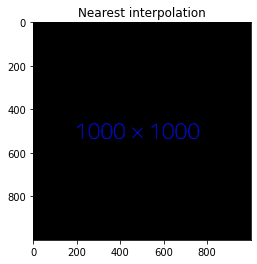

###### Bilinear Interpolation ######
Serial time:  35.69032096862793
Parallel time 0.005905s
Serial and Parallel Bilinear interpolation have the same result: True


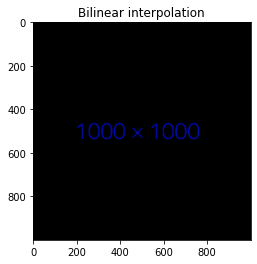

In [20]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt, floor, ceil
from PIL import Image
import math
from time import time

import pycuda.autoinit
import pycuda.driver as drv
import numpy as np
import sys
from time import perf_counter 
# returns the float value of time in seconds. 
#Return the value (in fractional seconds) of a performance counter, i.e. a clock with the highest available resolution to measure a short duration. 

from math import ceil
from pycuda import gpuarray
from pycuda.compiler import SourceModule

def read_image(path):
    '''Read image and return the image propertis.
    Parameters:
    path (string): Image path
    Returns:
    numpy.ndarray: Image exists in "path"
    list: Image size
    tuple: Image dimension (number of rows and columns)
    '''
    img = cv2.imread(path)  # cv2.IMREAD_GRAYSCALE)
    size = img.shape
    dimension = (size[0], size[1])

    return img, size, dimension


def image_change_scale(img, dimension, scale=100, interpolation=cv2.INTER_LINEAR):
    '''Resize image to a specificall scale of original image.
    Parameters:
    img (numpy.ndarray): Original image
    dimension (tuple): Original image dimension
    scale (int): Multiply the size of the original image
    Returns:
    numpy.ndarray: Resized image
    '''
    scale /= 100
    new_dimension = (int(dimension[1]*scale), int(dimension[0]*scale))
    resized_img = cv2.resize(img, new_dimension, interpolation=interpolation)

    return resized_img


def parallel_nearest_interpolation(image, dimension):
    '''Nearest neighbor interpolation method to convert small image to original image
    Parameters:
    img (numpy.ndarray): Small image
    dimension (tuple): resizing image dimension
    Returns:
    numpy.ndarray: Resized image
    '''
    enlarge_time = int(
        sqrt((dimension[0] * dimension[1]) / (image.shape[0]*image.shape[1])))
    
    dim=image.shape[2]
    image=image.astype(np.int32)
    image_gpu = gpuarray.to_gpu(image)
    new_image_gpu = gpuarray.empty((dimension[0],dimension[1],dim), np.int32)
    
    ker = SourceModule("""
                   __global__ void nearest_kernel(
                   int *image, int *new_image){
                    int high = %(high)s;
                    int width = %(width)s;
                    int dim = %(dim)s;
                    int enlarge_time = %(enlarge_time)s;
                    int width_original = (int)(width/enlarge_time);
                    int tx = blockIdx.x*blockDim.x+threadIdx.x;
                    int ty = blockIdx.y*blockDim.y+threadIdx.y;
                    int tz = blockIdx.z*blockDim.z+threadIdx.z;
                    int row,column;
                    if (tx < high && ty < width){
                      row = (int)(tx/enlarge_time);
                      column = (int)(ty/enlarge_time);
                      new_image[(tx * width * dim) + (ty * dim) + tz] = image[(row * width_original * dim) + (column * dim) + tz];
                    }
                   }"""%{'high': dimension[0], 'width': dimension[1], 'enlarge_time' : enlarge_time,'dim' : dim})
    
    nearest_gpu = ker.get_function("nearest_kernel")
    start = drv.Event()
    end=drv.Event()
    #Start Time
    start.record()

    nearest_gpu(image_gpu, new_image_gpu, block=(18,18,3), grid=(ceil(dimension[0]/18),ceil(dimension[1]/18),1))
    new_image = new_image_gpu.get()

    #End Time
    end.record()
    end.synchronize()
    #Measure time difference, give time in milliseconds, which is converted to seconds.
    secs = start.time_till(end)*1e-3
    print("Parallel time %fs" % (secs))
    
    image_gpu.gpudata.free()
    new_image_gpu.gpudata.free()
    return new_image,secs


def nearest_interpolation(image, dimension):
    '''Nearest neighbor interpolation method to convert small image to original image
    Parameters:
    img (numpy.ndarray): Small image
    dimension (tuple): resizing image dimension
    Returns:
    numpy.ndarray: Resized image
    '''
    new_image = np.zeros((dimension[0], dimension[1], image.shape[2]))

    enlarge_time = int(
        sqrt((dimension[0] * dimension[1]) / (image.shape[0]*image.shape[1])))
    start = time()
    for i in range(dimension[0]):
        for j in range(dimension[1]):
            row = floor(i / enlarge_time)
            column = floor(j / enlarge_time)

            new_image[i, j] = image[row, column]
    T=time()-start
    print("Serial Time:",T)
    return new_image,T

def parallel_bilinear_interpolation(image, dimension):
    '''Bilinear interpolation method to convert small image to original image
    Parameters:
    img (numpy.ndarray): Small image
    dimension (tuple): resizing image dimension
    Returns:
    numpy.ndarray: Resized image
    '''
    height = image.shape[0]
    width = image.shape[1]

    scale_x = (width)/(dimension[1])
    scale_y = (height)/(dimension[0])

    dim=image.shape[2]
    image=image.astype(np.int32)
    image_gpu = gpuarray.to_gpu(image)
    new_image_gpu = gpuarray.empty((dimension[0],dimension[1],dim), np.float32)
    ker = SourceModule("""
                   __global__ void bilinear_kernel(
                   int *image, float *new_image){
                    int high = %(high)s;
                    int width = %(width)s;
                    int dim = %(dim)s;
                    int tx = blockIdx.x*blockDim.x+threadIdx.x;
                    int ty = blockIdx.y*blockDim.y+threadIdx.y;
                    int tz = blockIdx.z*blockDim.z+threadIdx.z;
                    float x,y,x_diff,y_diff,pixel,a,b,c,d;
                    int x_int,y_int;
                    if (tx < high && ty < width){
                      x = (((float)ty)+0.5) * (%(scale_x)s) - 0.5;
                      y = (((float)tx)+0.5) * (%(scale_y)s) - 0.5;

                      x_int = (int)(x);
                      y_int = (int)(y);
                      if(x_int>%(width_original)s -2){x_int=%(width_original)s -2;}
                      if(y_int>%(height_original)s -2){y_int=%(height_original)s -2;}

                      x_diff = x - ((float)x_int);
                      y_diff = y - ((float)y_int);

                      a = (float)image[(y_int * %(width_original)s * dim) + (x_int * dim) + tz];
                      b = (float)image[(y_int * %(width_original)s * dim) + ((x_int+1) * dim) + tz];
                      c = (float)image[((y_int+1) * %(width_original)s * dim) + (x_int * dim) + tz];
                      d = (float)image[((y_int+1) * %(width_original)s * dim) + ((x_int+1) * dim) + tz];

                      pixel = (a*(1-x_diff)*(1-y_diff)) + (b*(x_diff) * (1-y_diff)) + (c*(1-x_diff) * (y_diff)) + (d*x_diff*y_diff);

                      new_image[(tx * width * dim) + (ty * dim) + tz] = pixel;
                    }
                   }"""%{'high': dimension[0], 'width': dimension[1],'dim' : dim, "scale_x" : scale_x,
                         "scale_y" : scale_y,'height_original': image.shape[0], 'width_original': image.shape[1]})
    
    bilinear_gpu = ker.get_function("bilinear_kernel")
    start = drv.Event()
    end=drv.Event()
    #Start Time
    start.record()

    bilinear_gpu(image_gpu, new_image_gpu, block=(18,18,3), grid=(ceil(dimension[0]/18),ceil(dimension[1]/18),1))
    new_image = new_image_gpu.get()
    
    #End Time
    end.record()
    end.synchronize()
    #Measure time difference, give time in milliseconds, which is converted to seconds.
    secs = start.time_till(end)*1e-3
    print("Parallel time %fs" % (secs))
    
    image_gpu.gpudata.free()
    new_image_gpu.gpudata.free()
    return new_image.astype(np.uint8),secs


def bilinear_interpolation(image, dimension):
    '''Bilinear interpolation method to convert small image to original image
    Parameters:
    img (numpy.ndarray): Small image
    dimension (tuple): resizing image dimension
    Returns:
    numpy.ndarray: Resized image
    '''
    height = image.shape[0]
    width = image.shape[1]

    scale_x = (width)/(dimension[1])
    scale_y = (height)/(dimension[0])

    new_image = np.zeros((dimension[0], dimension[1], image.shape[2]))
    start=time()
    for k in range(3):
        for i in range(dimension[0]):
            for j in range(dimension[1]):
                x = (j+0.5) * (scale_x) - 0.5
                y = (i+0.5) * (scale_y) - 0.5

                x_int = int(x)
                y_int = int(y)

                # Prevent crossing
                x_int = min(x_int, width-2)
                y_int = min(y_int, height-2)

                x_diff = x - x_int
                y_diff = y - y_int

                a = image[y_int, x_int, k]
                b = image[y_int, x_int+1, k]
                c = image[y_int+1, x_int, k]
                d = image[y_int+1, x_int+1, k]

                pixel = a*(1-x_diff)*(1-y_diff) + b*(x_diff) * \
                    (1-y_diff) + c*(1-x_diff) * (y_diff) + d*x_diff*y_diff
                
                new_image[i, j, k] = pixel.astype(np.uint8)
    T=time()-start
    print("Serial time: ",T)

    return new_image,T


def main():
    images_list = {}

    # Read Image
    img, size, dimension = read_image("img1000.png")
    print(f"Image size is: {size}")
    images_list['Original Image'] = img

    # Change Image Size
    scale_percent = 25  # percent of original image size
    resized_img = image_change_scale(img, dimension, scale_percent)
    print(f"Smalled Image size is: {resized_img.shape}")
    images_list['Smalled Image'] = resized_img

    #fig, axs = plt.subplots(2, 2) 
    #fig.suptitle('My Implementation', fontsize=16)

    # Change image to original size using nearest neighbor interpolation
    #s_nn_img = image_change_scale(
    #    resized_img, dimension, interpolation=cv2.INTER_NEAREST)
    #images_list['Nearest Neighbor Interpolation'] = s_nn_img

    # Change image to original size using bilinear interpolation
    #bil_img = image_change_scale(
    #    resized_img, dimension, interpolation=cv2.INTER_LINEAR)
    #images_list['Bilinear Interpolation'] = bil_img

    #######    nearest_interpolation   #########
    print("#"*6,"Nearest Interpolation","#"*6)
    nn_img_algo_S,TSN = nearest_interpolation(resized_img, dimension)
    #nn_img_algo_SN = Image.fromarray(nn_img_algo_S.astype('uint8')).convert('RGB')

    nn_img_algo_P,TPN = parallel_nearest_interpolation(resized_img, dimension)
    nn_img_algo_PN = Image.fromarray(nn_img_algo_P.astype('uint8')).convert('RGB')

    print("Serial and Parallel Nearest interpolation have the same result:",(nn_img_algo_S==nn_img_algo_P).all())
    plt.title("Nearest interpolation")
    plt.imshow(cv2.cvtColor(np.array(nn_img_algo_PN), cv2.COLOR_BGR2RGB))
    plt.show()

    #######   bilinear interpolation ###########
    print("#"*6,"Bilinear Interpolation","#"*6)
    bil_img_algo_S,TSB = bilinear_interpolation(resized_img, dimension)
    #bil_img_algo_SN = Image.fromarray(bil_img_algo_S.astype('uint8')).convert('RGB')

    bil_img_algo_P,TPB=parallel_bilinear_interpolation(resized_img, dimension)
    bil_img_algo_NP = Image.fromarray(bil_img_algo_P.astype('uint8')).convert('RGB')

    print("Serial and Parallel Bilinear interpolation have the same result:",(bil_img_algo_S==bil_img_algo_P).all())
    plt.title("Bilinear interpolation")
    plt.imshow(cv2.cvtColor(np.array(bil_img_algo_NP), cv2.COLOR_BGR2RGB))
    plt.show()


def testCase(resized_img,dimension):
    #######    nearest_interpolation   #########
    nn_img_algo_S,TSN = nearest_interpolation(resized_img, dimension)
    #nn_img_algo_SN = Image.fromarray(nn_img_algo_S.astype('uint8')).convert('RGB')

    nn_img_algo_P,TPN = parallel_nearest_interpolation(resized_img, dimension)
    #nn_img_algo_PN = Image.fromarray(nn_img_algo.astype('uint8')).convert('RGB')

    #print((nn_img_algo_S==nn_img_algo_P).all())
    #plt.imshow(cv2.cvtColor(np.array(nn_img_algo_PN), cv2.COLOR_BGR2RGB))

    #######   bilinear interpolation ###########
    bil_img_algo_S,TSB = bilinear_interpolation(resized_img, dimension)
    #bil_img_algo_SN = Image.fromarray(bil_img_algo_S.astype('uint8')).convert('RGB')

    bil_img_algo_P,TPB=parallel_bilinear_interpolation(resized_img, dimension)
    #bil_img_algo_NP = Image.fromarray(bil_img_algo_P.astype('uint8')).convert('RGB')

    #print((bil_img_algo_S==bil_img_algo_P).all())
    #plt.imshow(cv2.cvtColor(np.array(bil_img_algo_NP), cv2.COLOR_BGR2RGB))

    return TSN,TPN,TSB,TPB


def test():
    #nearest_interpolation
    StimesMean_N=list()
    PtimesMean_N=list()
    StimesSTD_N=list()
    PtimesSTD_N=list()
    #bilinear interpolation
    StimesMean_B=list()
    PtimesMean_B=list()
    StimesSTD_B=list()
    PtimesSTD_B=list()
    for i in range(1,15):
      #generate image
      size=300
      dimension=(i*size,i*size,3)
      resized_img = np.random.randn(int((i*size)/4), int((i*size)/4),3).astype(np.int32)
      print(f"Image size is: {i*size} x {i*size}")
      print(f"Smalled Image size is: {resized_img.shape}")

      eachS_B=list()
      eachP_B=list()
      eachS_N=list()
      eachP_N=list()
      for _ in range(2):
        TSN,TPN,TSB,TPB = testCase(resized_img,dimension)
        eachS_B.append(TSB)
        eachP_B.append(TPB)
        eachS_N.append(TSN)
        eachP_N.append(TPN)

      StimesMean_N.append(np.mean(eachS_N))
      PtimesMean_N.append(np.mean(eachP_N))
      StimesSTD_N.append(np.std(eachS_N))
      PtimesSTD_N.append(np.std(eachP_N))
      StimesMean_B.append(np.mean(eachS_B))
      PtimesMean_B.append(np.mean(eachP_B))
      StimesSTD_B.append(np.std(eachS_B))
      PtimesSTD_B.append(np.std(eachP_B))
    print("#"*10, "nearest_interpolation")
    print("Means S:")
    print("\n".join([str(x) for x in StimesMean_N]))
    print("Means P:")
    print("\n".join([str(x) for x in PtimesMean_N]))
    print("STD S:")
    print("\n".join([str(x) for x in StimesSTD_N]))
    print("STD P:")
    print("\n".join([str(x) for x in PtimesSTD_N]))
    print("#"*10, "bilinear interpolation")
    print("Means S:")
    print("\n".join([str(x) for x in StimesMean_B]))
    print("Means P:")
    print("\n".join([str(x) for x in PtimesMean_B]))
    print("STD S:")
    print("\n".join([str(x) for x in StimesSTD_B]))
    print("STD P:")
    print("\n".join([str(x) for x in PtimesSTD_B]))


if __name__ == "__main__":
    main()

In [12]:
##Graphics
import matplotlib.pyplot as plt
Sizes=[i*300 for i in range(1,15)]
Time_NN_S =[0.09145581722259521,
            0.3792724609375,
            0.8307764530181885,
            1.4688963890075684,
            2.2496185302734375,
            3.190272569656372,
            4.349600672721863,
            5.6481791734695435,
            7.59816312789917,
            9.548685908317566,
            11.349884867668152,
            13.695192575454712,
            16.096909999847412,
            19.016935229301453]
Time_NN_P= [0.0008677599728107452,
            0.002148864030838013,
            0.0035675199031829836,
            0.005971711874008179,
            0.006952095985412598,
            0.010859407901763917,
            0.014921919345855714,
            0.019588960647583007,
            0.02345844841003418,
            0.027901599884033203,
            0.03185894393920899,
            0.042555503845214844,
            0.05202248001098633,
            0.052321231842041016]
Time_B_S =[3.271628499031067,
          13.006005883216858,
          28.846412301063538,
          51.53458547592163,
          79.90670537948608,
          115.51340126991272,
          156.20582056045532,
          203.58920979499817,
          289.10896158218384,
          337.93328619003296,
          410.15705716609955,
          492.63513910770416,
          586.2668241262436,
          683.2191070318222]
Time_B_P=[0.0008010880053043365,
          0.00212363201379776,
          0.004474815964698791,
          0.00789361596107483,
          0.008444464206695555,
          0.01408847951889038,
          0.018749760150909425,
          0.024565728187561038,
          0.03319380855560303,
          0.03428388786315918,
          0.04716508865356446,
          0.05611199760437012,
          0.055565774917602534,
          0.06714672088623047]


STD_NN_S=[0.0014280080795288086,
          0.00550532341003418,
          0.009176254272460938,
          0.008975744247436523,
          0.012794256210327148,
          0.01700735092163086,
          0.016822457313537598,
          0.02104771137237549,
          0.4294319152832031,
          0.2103632688522339,
          0.021217942237854004,
          0.07766175270080566,
          0.3346562385559082,
          0.30627548694610596]

STD_B_S= [0.006901860237121582,
          0.01912248134613037,
          0.2727140188217163,
          0.24746251106262207,
          0.08445477485656738,
          0.34929370880126953,
          0.203995943069458,
          0.501983642578125,
          0.4829521179199219,
          1.5588858127593994,
          4.5236839056015015,
          0.1416560411453247,
          2.241022229194641,
          2.9496480226516724]

STD_NN_P =   [0.0001689439713954926,
              1.73759460449219e-05,
              0.00034435200691223166,
              0.0012208640575408938,
              0.0001819519996643067,
              0.0013265442848205567,
              0.0017400317192077632,
              0.002317855834960938,
              0.001882543563842775,
              0.00012857627868652355,
              0.00048534393310547055,
              0.004743598937988279,
              0.007981777191162113,
              1.0513305664060224e-05]

STD_B_P =  [0.0001786240041255951,
            0.00019496005773544326,
            0.0006616638898849486,
            0.0009174878597259526,
            0.000282479763031006,
            0.003319391727447509,
            0.003976800441741944,
            0.0052319993972778315,
            0.007167344093322755,
            0.0013530063629150386,
            0.009333183288574218,
            0.012581087112426757,
            0.001360368728637696,
            0.007710144042968752]



In [14]:
for i in range(len(Sizes)):
  print("{0} & {1} & {2} \\\\".format(Sizes[i],round(Time_B_P[i],5),round(STD_B_P[i],5)))

300 & 0.0008 & 0.00018 \\
600 & 0.00212 & 0.00019 \\
900 & 0.00447 & 0.00066 \\
1200 & 0.00789 & 0.00092 \\
1500 & 0.00844 & 0.00028 \\
1800 & 0.01409 & 0.00332 \\
2100 & 0.01875 & 0.00398 \\
2400 & 0.02457 & 0.00523 \\
2700 & 0.03319 & 0.00717 \\
3000 & 0.03428 & 0.00135 \\
3300 & 0.04717 & 0.00933 \\
3600 & 0.05611 & 0.01258 \\
3900 & 0.05557 & 0.00136 \\
4200 & 0.06715 & 0.00771 \\


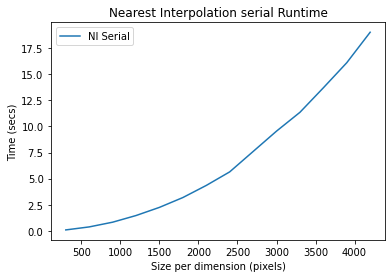

In [3]:
plt.title("Nearest Interpolation serial Runtime")
plt.plot(Sizes,Time_NN_S,label="NI Serial")
plt.ylabel("Time (secs)")
plt.xlabel("Size per dimension (pixels)")
plt.legend()
plt.show()

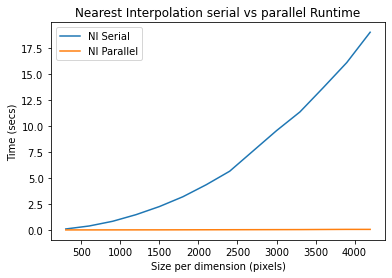

In [4]:
plt.title("Nearest Interpolation serial vs parallel Runtime")
plt.plot(Sizes,Time_NN_S,label="NI Serial")
plt.plot(Sizes,Time_NN_P,label="NI Parallel")
plt.ylabel("Time (secs)")
plt.xlabel("Size per dimension (pixels)")
plt.legend()
plt.show()

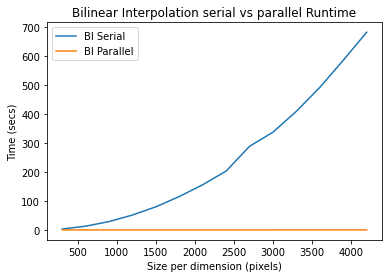

In [6]:
plt.title("Bilinear Interpolation serial vs parallel Runtime")
plt.plot(Sizes,Time_B_S,label="BI Serial")
plt.plot(Sizes,Time_B_P,label="BI Parallel")
plt.ylabel("Time (secs)")
plt.xlabel("Size per dimension (pixels)")
plt.legend()
plt.show()

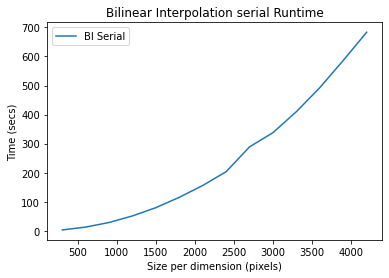

In [7]:
plt.title("Bilinear Interpolation serial Runtime")
plt.plot(Sizes,Time_B_S,label="BI Serial")
plt.ylabel("Time (secs)")
plt.xlabel("Size per dimension (pixels)")
plt.legend()
plt.show()

In [8]:
#SpeedUP
import numpy as np
speedup_NN=np.array(Time_NN_S)/np.array(Time_NN_P)
speedup_B=np.array(Time_B_S)/np.array(Time_B_P)

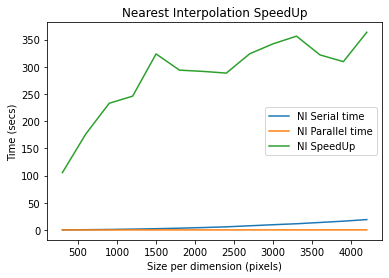

In [9]:
plt.title("Nearest Interpolation SpeedUp")
plt.plot(Sizes,Time_NN_S,label="NI Serial time")
plt.plot(Sizes,Time_NN_P,label="NI Parallel time")
plt.plot(Sizes,speedup_NN,label="NI SpeedUp")
plt.ylabel("Time (secs)")
plt.xlabel("Size per dimension (pixels)")
plt.legend()
plt.show()

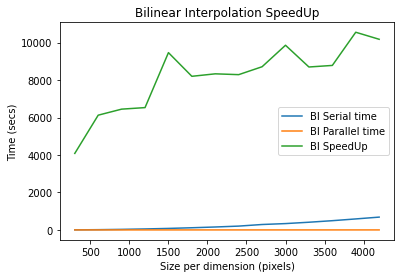

In [10]:
plt.title("Bilinear Interpolation SpeedUp")
plt.plot(Sizes,Time_B_S,label="BI Serial time")
plt.plot(Sizes,Time_B_P,label="BI Parallel time")
plt.plot(Sizes,speedup_B,label="BI SpeedUp")
plt.ylabel("Time (secs)")
plt.xlabel("Size per dimension (pixels)")
plt.legend()
plt.show()

In [22]:
#Ram
import sys
Ram_N = [((((((Sizes[i]**2)*3))*sys.getsizeof(int))/(1024**3))/2)+0.66 for i in range(len(Sizes))]
Ram_B = [((((((Sizes[i]**2)*3))*sys.getsizeof(int))/(1024**3))/2)+0.8 for i in range(len(Sizes))]

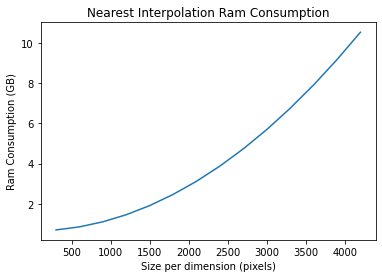

In [24]:
plt.title("Nearest Interpolation Ram Consumption")
plt.plot(Sizes,Ram_N)
plt.ylabel("Ram Consumption (GB)")
plt.xlabel("Size per dimension (pixels)")
plt.show()

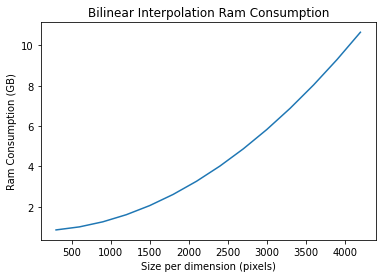

In [25]:
plt.title("Bilinear Interpolation Ram Consumption")
plt.plot(Sizes,Ram_B)
plt.ylabel("Ram Consumption (GB)")
plt.xlabel("Size per dimension (pixels)")
plt.show()

In [ ]:
#Comparative Nearest vs Bilinear

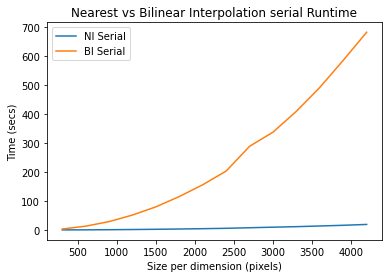

In [26]:
plt.title("Nearest vs Bilinear Interpolation serial Runtime")
plt.plot(Sizes,Time_NN_S,label="NI Serial")
plt.plot(Sizes,Time_B_S,label="BI Serial")
plt.ylabel("Time (secs)")
plt.xlabel("Size per dimension (pixels)")
plt.legend()
plt.show()

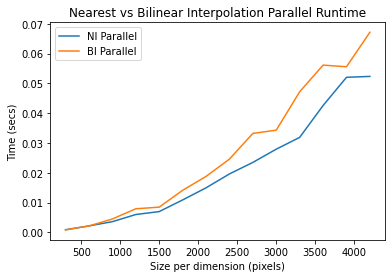

In [27]:
plt.title("Nearest vs Bilinear Interpolation Parallel Runtime")
plt.plot(Sizes,Time_NN_P,label="NI Parallel")
plt.plot(Sizes,Time_B_P,label="BI Parallel")
plt.ylabel("Time (secs)")
plt.xlabel("Size per dimension (pixels)")
plt.legend()
plt.show()

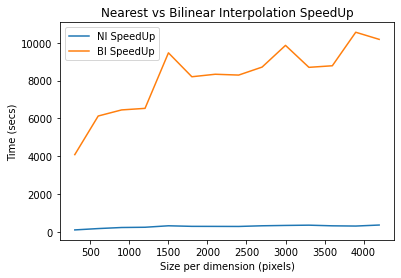

In [28]:
plt.title("Nearest vs Bilinear Interpolation SpeedUp")
plt.plot(Sizes,speedup_NN,label="NI SpeedUp")
plt.plot(Sizes,speedup_B,label="BI SpeedUp")
plt.ylabel("Time (secs)")
plt.xlabel("Size per dimension (pixels)")
plt.legend()
plt.show()